In [1]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Activation, Dense, Convolution2D, MaxPooling2D, Flatten, Lambda, Cropping2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [2]:
# load csv
def load_and_split_data(data_dir, test_size=0.2, file_names=None, load_three=False, steer_left=0.08, steer_right=0.04):
    files = []
    if file_names == None:  # if not assined, then using all the training data
        files = glob(data_dir + "*/*.csv")
    else:
        files = [(data_dir + f + "/driving_log.csv") for f in file_names]
    samples = []
    for f in files:
        with open(f) as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                steer_center = float(line[3])
                if load_three:
                    samples.append(["." + line[0][line[0].find("/data/"):], steer_center])
                    samples.append(["." + line[1][line[1].find("/data/"):], steer_center + steer_left])
                    samples.append(["." + line[2][line[2].find("/data/"):], steer_center - steer_right])
                else:
                    samples.append(["." + line[0][line[0].find("/data/"):], steer_center])
                    
    train_samples, validation_samples = train_test_split(samples, test_size=test_size)
    return train_samples, validation_samples

# the data generator
def generator(samples, batch_size=32, with_shuffle=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if with_shuffle:
            shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for sample in batch_samples:
                images.append(cv2.imread(sample[0]))
                angles.append(sample[1])
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train) if with_shuffle else (X_train, y_train)

In [3]:
# the Nivida Paper 
# (http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) 
# 
def Nivdia(dropout_ratio=0.5):
    model = Sequential()
    model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    
    model.add(Convolution2D(3, 5, 5, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_ratio))

    model.add(Convolution2D(24, 5, 5, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_ratio))

    model.add(Convolution2D(36, 3, 3, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_ratio))

    model.add(Convolution2D(16, 3, 3, border_mode="valid", activation="relu"))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout_ratio))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation("relu"))

    model.add(Dense(84))
    model.add(Activation("relu"))

    model.add(Dense(1))
    return model


33885 8472
Epoch 1/20
33885/33885 [==============================] - 462s - loss: 0.0731 - val_loss: 0.0651
Epoch 2/20
33885/33885 [==============================] - 460s - loss: 0.0705 - val_loss: 0.0658
Epoch 3/20
33885/33885 [==============================] - 460s - loss: 0.0700 - val_loss: 0.0655
Epoch 4/20
33885/33885 [==============================] - 460s - loss: 0.0695 - val_loss: 0.0661
Epoch 00003: early stopping
dict_keys(['val_loss', 'loss'])


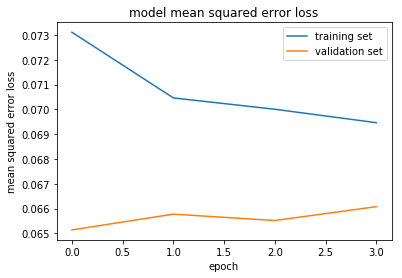

In [5]:
model = Nivdia(dropout_ratio=0.25)

train_samples, validation_samples = load_and_split_data('./data/', 
#                                                         file_names=["0314", "0319-2", "0311"], 
                                                        file_names=["0314", "0319-2", "0311", "0319"],                                                     
                                                        load_three=True,
                                                        steer_left=0.04,
                                                        steer_right=0.04
                                                       )

print(len(train_samples), len(validation_samples))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.compile(loss='mse', optimizer="adam")


'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpointer = ModelCheckpoint(filepath="./weights.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')
history_object = model.fit_generator(train_generator, samples_per_epoch= \
                len(train_samples), validation_data=validation_generator, 
                nb_val_samples=len(validation_samples), nb_epoch=20, callbacks=[checkpointer, earlyStopping])

model.save("model-lenet-0322.h5")

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


In [ ]:
# samples = []
# data_dir = './data/track1/20170304/'
# with open(data_dir + 'driving_log.csv') as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         samples.append(line)

# train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# def generator(samples, batch_size=32):
#     num_samples = len(samples)
#     while 1: # Loop forever so the generator never terminates
#         shuffle(samples)
#         for offset in range(0, num_samples, batch_size):
#             batch_samples = samples[offset:offset+batch_size]

#             images = []
#             angles = []
#             for batch_sample in batch_samples:
#                 name = data_dir + './IMG/'+batch_sample[0].split('/')[-1]
#                 center_image = cv2.imread(name)
#                 center_angle = float(batch_sample[3])
#                 images.append(center_image)
#                 angles.append(center_angle)

#             # trim image to only see section with road
#             X_train = np.array(images)
#             y_train = np.array(angles)
#             yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
# validation_generator = generator(validation_samples, batch_size=32)

In [ ]:
for X_train in next(train_generator):
    len(X_train)